In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from contrastive import CPCA	# $ pip3 install contrastive
import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D
import math

from collections import defaultdict
from tensorly.decomposition import parafac
import tensorly as tl
tl.set_backend('numpy')
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from utilities.utils import get_n_ROI, vec_to_symmetric_matrix

################## Set for your dataset name ##################
DATASET = "real_timefreq" # real dFC dataset assessed by time frequency method

In [23]:
# Load configuration file for filepath
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
my_filepath = config["datasets"][DATASET]["path"]

# Loading dataset for 1 task paradigm assessed by 1 method for all subjects (1 run)
dFC = np.load(data_filepath, allow_pickle=True)
dFC_dict = dFC.item() # extract the dictionary from np array

# Dictionary structure: 
# obs_total = combinations of different subjects at different time points.
# ROI * (ROI-1) / 2 unique connections
# {
#   'X': array([[...]...]),        # concatenated matrix for dim. reduction: shape (obs_total × 4950)
#   'y': array([...]),             # binary task/rest labels for each observation/row: shape (obs_total,)
#   'subj_label': array([...]),   # subject for each observation/row: shape (obs_total,)
#   'measure_name': 'Time-Freq'   # dFC assessment method name
# }

# print(display(dFC_dict))

X = dFC_dict["X"]
y = dFC_dict["y"]
subj_label = dFC_dict["subj_label"]
method = dFC_dict["measure_name"] 

ROI = get_n_ROI(1, -1, -2 * X.shape[1])  # solves quadratic equation for number of ROIs

In [57]:
# Load the information about the regions of interest (ROIs)
regions_info = np.load(regions_filepath, allow_pickle=True)
regions_dict = regions_info.item()

# Each ROI is represented by a 
# label (7Networks_<hemisphere>_<network>_<region number for that network>)
# and a location in 3D space.
region_label = regions_dict['node_labels']
region_loc = regions_dict['node_locs']
display(region_label[:5])

['7Networks_LH_Vis_1',
 '7Networks_LH_Vis_2',
 '7Networks_LH_Vis_3',
 '7Networks_LH_Vis_4',
 '7Networks_LH_Vis_5']

Text(0.5, 1.0, 'Covariance Matrix for PCA Eigendecomposition')

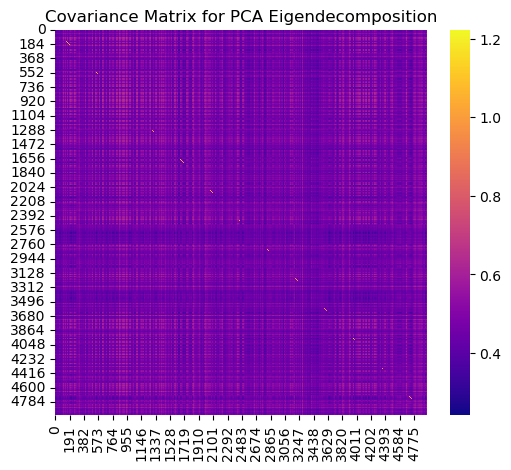

In [12]:
# Sample covariance matrix for PCA

scaler_X = StandardScaler()
scaled_X = scaler_X.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(scaled_X)

covariance_mat = pca.get_covariance()

plt.figure(figsize=(6, 5))
sns.heatmap(
	covariance_mat,
	cmap="plasma"
)
plt.title("Covariance Matrix for PCA Eigendecomposition")


In [3]:
# # If want to analyze for just one subject at a time
# unique_subj = np.unique(subj_label) # 27 subjects

# # First subject
# X_0 = X[subj_label == subj_label[0]] # filter using mask of length obs_total
# y_0 = y[subj_label == subj_label[0]]


In [39]:
# Scatter biplot. Each point represents a dFC matrix object.
def biplot(X, labels=None, filtered=False, technique="PCA"):
	# filtered is for in the future if done some feature selection
	plt.figure(figsize=(6, 3))
  
	if technique == "PCA":
		pipeline = make_pipeline(StandardScaler(),
							PCA(n_components=2))
		X_reduced = pipeline.fit_transform(X)
		pca = pipeline.named_steps["pca"] # access PCA object
		explained_var = pca.explained_variance_ratio_
		plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}%)")
		plt.ylabel(f"PC2 ({explained_var[1]*100:.1f}%)")
	
	elif technique == "CPD": # Canonical Polyadic Decomposition
		subj_tensor_dict = build_subject_tensors(X, subj_label)
		time_X, time_y = extract_time_factors_cp(subj_tensor_dict, subj_label, labels, cp_rank=2)
		X_reduced = time_X	# time factors
		labels = time_y	# task labels only for time points valid for CPD
		plt.xlabel("CP Time Tensor Component 1")
		plt.ylabel("CP Time Tensor Component 2")
  
	else:
		raise ValueError("Technique not implemented. Use PCA or CPD.")

	if labels is not None: # labelling dFC matrices by task-presence
		unique_labels = [0, 1]
		colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
	
		word_labels = ["Rest", "Task-active"]
		for i in unique_labels:
			mask = labels == i
			plt.scatter(X_reduced[mask, 0], X_reduced[mask, 1], s=40, alpha=0.7,
						label=word_labels[i], color=colors[i])
	else:
		plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s=40, alpha=0.7, color="gray")

	
	plt.gca().set_aspect('auto')  # default (components scaled independently)
	if filtered == True:
		plt.title(f"Filtered {technique} Biplot")
	else:
		plt.title(f"{technique} Biplot")
	if labels is not None:
		plt.legend()
	plt.grid(True)
	plt.show()


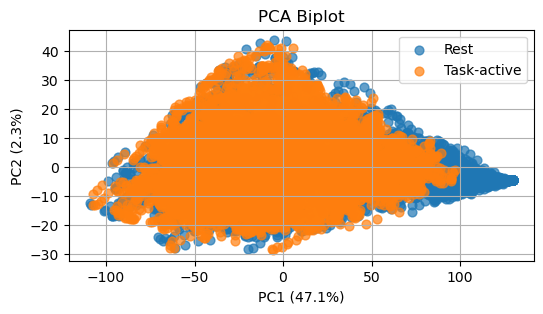

In [15]:
biplot(X, labels=y)

In [18]:
def scree_plot(X, technique, n_components, Y=None, alpha=None):
	scaler_X = StandardScaler()
	X_scaled = scaler_X.fit_transform(X)
	if Y is not None: # Y is the second dataset to necessary to perform CCA and CPCA
		scaler_Y = StandardScaler()
		Y_scaled = scaler_Y.fit_transform(Y)
  
	model = technique(n_components=n_components)

	if technique.__name__ == 'PCA':
		model.fit(X_scaled)
		explained_var = model.explained_variance_ratio_

	elif technique.__name__ == 'CCA':
		if Y is None:
			raise ValueError("CCA requires a second dataset Y.")

		# First use PCA to reduce dimensionality. Else very long run time
		# If do 328 components, retains 90% of variance in the original dataset
		pca_x = PCA(n_components=max(n_components, 1000))
		pca_y = PCA(n_components=max(n_components, 1000))
		X_reduced = pca_x.fit_transform(X_scaled)
		Y_reduced = pca_y.fit_transform(Y_scaled)

		# Then apply CCA
		X_c, Y_c = model.fit_transform(X_reduced, Y_reduced)
		# Use squared canonical correlations as proxy for variance explained for each component. 
		# Gives the proportion of shared variance between the ith canonical variables (projections)
		# from X and Y
		explained_var = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1]**2 for i in range(X_c.shape[1])]

	elif technique.__name__ == 'CPCA':
		if Y is None or alpha is None:
			raise ValueError("CPCA requires a background dataset Y and",
					"visualization needs prespecified alpha.")
		model.fit_transform(X_scaled, Y_scaled, alpha_selection='manual', alpha_value=alpha)	# target, background
		
		# compute variance explained (eigenvalues) per component
		contrastive_covar_matrix = model.fg_cov - alpha * model.bg_cov
		eigenvalues, _ = np.linalg.eigh(contrastive_covar_matrix)

		# warning for variance interpretation
		if np.sum(eigenvalues) < 0:
			print("Warning: Many cPCs explain negative variance. Consider reducing alpha.")
		eigenvalues = np.clip(eigenvalues, a_min=0, a_max=None) # don't keep negative ev = variances
  
		sorted_ev = np.sort(np.real(eigenvalues))[::-1] # descending
		top_n = sorted_ev[:n_components]
		explained_var = top_n / np.sum(sorted_ev)

	else:
		raise ValueError("Only PCA, CCA, and CPCA are supported right now.")

	print("EV by 1st Component:", explained_var[0])
	print("EV by 2nd Component:", explained_var[1])
	# Plot
	plt.figure(figsize=(6, 4))
	plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', 
				linestyle='-', label='Individual', color="green")
	plt.plot(range(1, len(explained_var)+1), np.cumsum(explained_var),
				linestyle='--', label='Cumulative', color='blue')
 
	plt.title(f"{technique.__name__} Scree Plot")
	plt.xlabel('Component')
	plt.xticks(range(0, len(explained_var)+1, n_components//10 + 1))
	if technique.__name__ == 'CCA':
		plt.ylabel('Squared Canonical Correlation (r²)')
	else:
		plt.ylabel('Explained Variance')
	plt.ylim(0.0, 1.0)
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

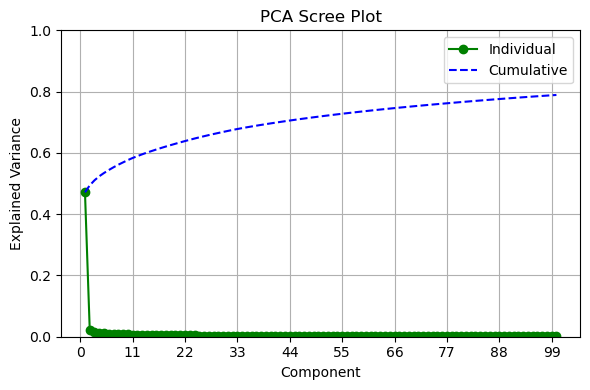

In [23]:
# For all time points
scree_plot(X, technique=PCA, n_components=100) # pass PCA as a class object

In [19]:
def loading_heatmap(X, technique, Y=None, which_component=1, alpha=None):
	# Visualize each connection's absolute contribution to specified PC as a heatmap
	loading_matrix = np.zeros((ROI, ROI))
 
	scaler_X = StandardScaler()
	X_scaled = scaler_X.fit_transform(X)
	if Y is not None: # Y is the second dataset to necessary to perform CCA and CPCA
		scaler_Y = StandardScaler()
		Y_scaled = scaler_Y.fit_transform(Y)
	
	model = technique(n_components=which_component+1)	# to debug CPCA when which_component=1

	if technique.__name__ == "PCA":
		model.fit(X_scaled)
		loadings = model.components_[which_component-1]       # shape = (1, n_connections)
  
  
	elif technique.__name__ == 'CCA':
		if Y is None:
			raise ValueError("CCA requires a second dataset Y.")

		# First use PCA to reduce dimensionality. Else very long run time
		pca_x = PCA(n_components=1000)
		pca_y = PCA(n_components=1000)
		X_reduced = pca_x.fit_transform(X_scaled)
		Y_reduced = pca_y.fit_transform(Y_scaled)

		# Then apply CCA
		model.fit(X_reduced, Y_reduced)

		# Canonical loadings (projection weights)
		# # loadings in PCA space! Note: x_weights_ is already sorted by descending eigenvalues
		a1 = model.x_weights_[:, which_component-1]  # shape = (n_features_PCA,)
		b1 = model.y_weights_[:, which_component-1]  # shape = (n_features_PCA,)
		# map loadings back to original feature space via principle components (basis)
		loadings = pca_x.components_.T @ a1
		loadings_y = pca_y.components_.T @ b1

	elif technique.__name__ == 'CPCA':
		if Y is None or alpha is None:
			raise ValueError("CPCA requires a background dataset Y and",
					"visualization needs prespecified alpha.")
   
		# First use PCA to reduce dimensionality. Set to 1000 because this is what
		# the contrastive library implicitly implements as a preprocessing step
		pca = PCA(n_components=1000)
		X_reduced = pca.fit_transform(X_scaled)
		# Important: cPCA assumes both datasets live in the same (PCA-reduced) 
		# feature space for the subtraction to be meaningful.
		# So, transform Y on the same PC basis that was fitted using X
		Y_reduced = pca.transform(Y_scaled)
  
		model.fit_transform(X_reduced, Y_reduced, alpha_selection='manual', alpha_value=alpha)	# target, background
		
  		# get the eigenvectors = loadings
		contrastive_covar_matrix = model.fg_cov - alpha * model.bg_cov
		eigenvalues, eigenvectors = np.linalg.eigh(contrastive_covar_matrix)

		# sort to descending order
		sorted_idx = np.argsort(eigenvalues)[::-1]
		eigenvectors_desc = eigenvectors[:, sorted_idx]
		loadings_pca = eigenvectors_desc[:, which_component-1]	
  		# loadings shape = (1000,) because in PCA-reduced space. Map back!
		loadings = pca.components_.T @ loadings_pca
  
	else:
		raise ValueError("Only PCA, CCA, and CPCA are supported right now.")


	upper_tri_ind = np.triu_indices(ROI, k=1) # excluding diagonal
	loading_matrix[upper_tri_ind] = loadings
	loading_matrix = loading_matrix + loading_matrix.T # add symmetric lower triangle
 
	plt.figure(figsize=(6, 5))
	sns.heatmap(
		loading_matrix,
		cmap="vlag",
		square=True,
		center=0.0
  	)
	plt.title(f"{technique.__name__}{which_component} Loadings as dFC Heatmap")

	if technique.__name__ == 'CCA':
		# need additional heatmap for Y dataset
		loading_matrix_y = np.zeros((ROI, ROI))
  
		loading_matrix_y[upper_tri_ind] = loadings_y
		loading_matrix_y = loading_matrix_y + loading_matrix_y.T
	
		plt.figure(figsize=(6, 5))
		sns.heatmap(
			loading_matrix_y,
			cmap="vlag",
			square=True,
			center=0.0
		)
		plt.title(f"{technique.__name__}{which_component} Loadings as dFC Heatmap (for Y)")


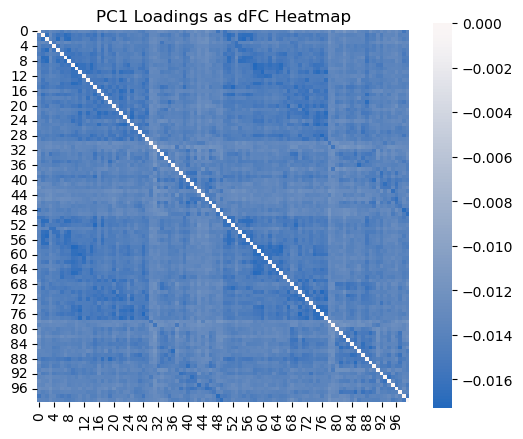

In [20]:
loading_heatmap(X, technique=PCA, which_component=1)

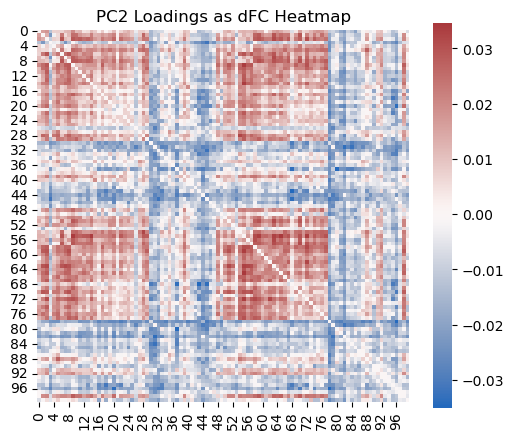

In [21]:
loading_heatmap(X, technique=PCA, which_component=2)

In [12]:
# CCA: Task vs rest approach data prep

# First split X into time points at rest vs task and scale
X_rest = X[y==0]
X_task = X[y==1]

# Only for CCA
# However, CCA aligns the projections, so it needs sample sizes from X and Y to equal
# So, randomly downsample
min_rows = min(len(X_task), len(X_rest))
np.random.seed(25)
rest_indices = np.random.choice(len(X_rest), size=min_rows, replace=False)
task_indices = np.random.choice(len(X_task), size=min_rows, replace=False)

X_rest_sampled = X_rest[rest_indices]
X_task_sampled = X_task[task_indices]


/Users/kinichen/miniconda3/envs/neuro_jb_lab_env/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


EV by 1st Component: 0.22364608103423642
EV by 2nd Component: 0.2223905587805528


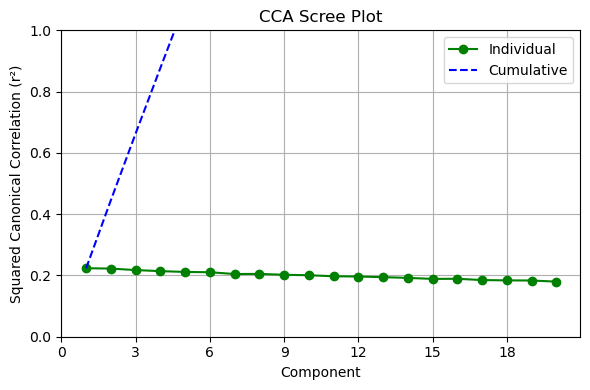

In [16]:
# Optional: Do supervised Canonical Correlation Analysis (CCA) between X and y 
# for dim reduction (did in model_classification.ipynb)

# Do CCA between rest vs task (for interpreting resting state as background or not)
scree_plot(X=X_rest_sampled, Y=X_task_sampled, technique=CCA, n_components=20)

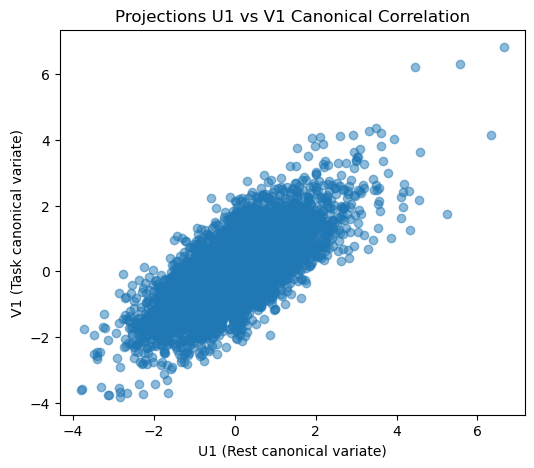

Canonical correlation (r): 0.712758299502831


In [17]:
# See how well the first canonical dimension aligns between rest and task
# CCA is actually designed to optimize this
# First use PCA to reduce dimensionality. Else very long run time
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_rest_sampled)
scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(X_task_sampled)
  
pca_x = PCA(n_components=1000)
pca_y = PCA(n_components=1000)
X_reduced = pca_x.fit_transform(X_scaled)
Y_reduced = pca_y.fit_transform(Y_scaled)

cca = CCA(n_components=1)
U, V = cca.fit_transform(X_reduced, Y_reduced)

plt.figure(figsize=(6, 5))
plt.scatter(U, V, alpha=0.5)
plt.xlabel("U1 (Rest canonical variate)")
plt.ylabel("V1 (Task canonical variate)")
plt.title("Projections U1 vs V1 Canonical Correlation")
plt.show()

print("Canonical correlation (r):", np.corrcoef(U[:, 0], V[:, 0])[0, 1])


/Users/kinichen/miniconda3/envs/neuro_jb_lab_env/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


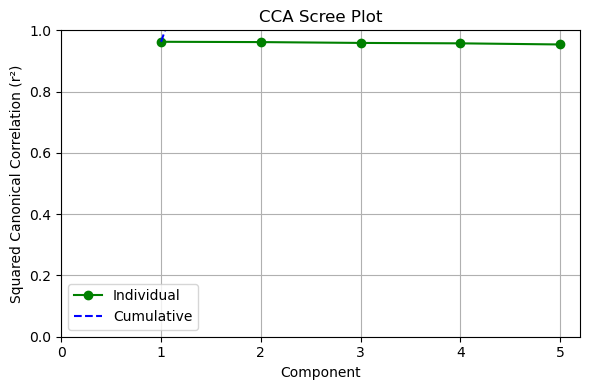

In [26]:
# Simulation to check if CCA is working properly. Create HIGHLY correlated X and Y
X_sim = np.random.randn(500, 1000)
Y_sim = X_sim[:, :500] + np.random.randn(500, 500) * 0.001  # Highly correlated (little noise)

scree_plot(X=X_sim, Y=Y_sim, technique=CCA, n_components=5) # indeed almost 1 correlation

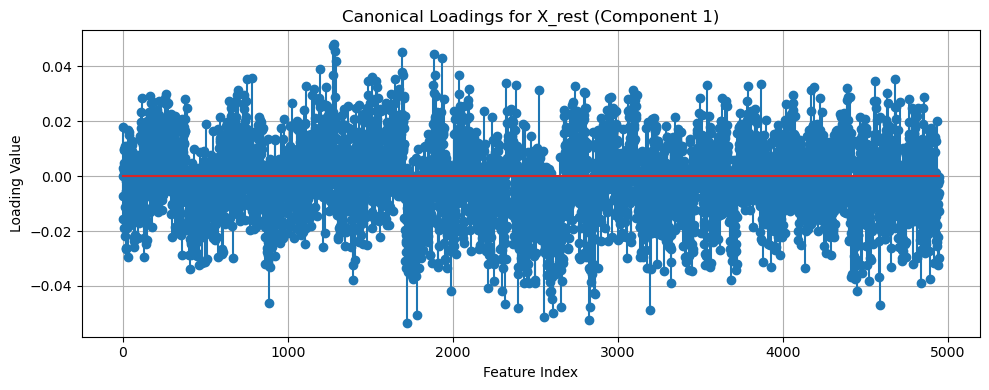

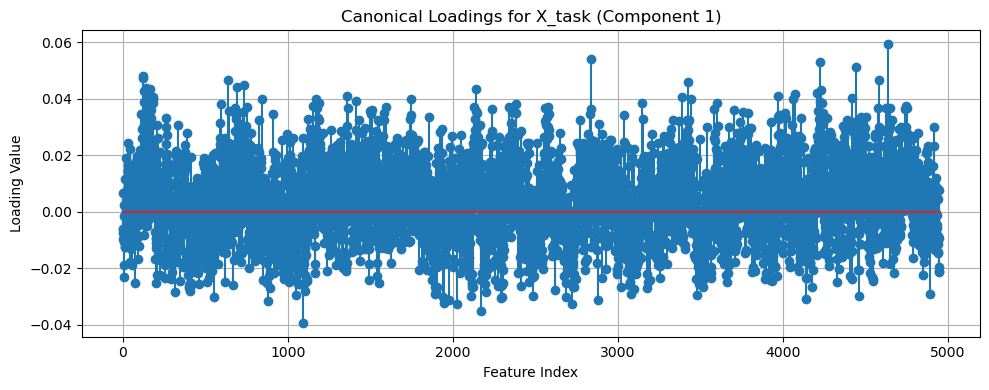

In [37]:
# CCA loadings for rest vs task
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_rest_sampled)
scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(X_task_sampled)
  
pca_x = PCA(n_components=1000)
pca_y = PCA(n_components=1000)
X_reduced = pca_x.fit_transform(X_scaled)
Y_reduced = pca_y.fit_transform(Y_scaled)

cca = CCA(n_components=1)
cca.fit(X_reduced, Y_reduced)
# Canonical loadings (projection weights)
a1 = cca.x_weights_[:, 0]  # shape = (n_features_PCA,)	# loadings in PCA space!
b1 = cca.y_weights_[:, 0]  # shape = (n_features_PCA,)
# map loadings back to original feature space via principle components (basis)
a1_original = pca_x.components_.T @ a1
b1_original = pca_y.components_.T @ b1


# For X_rest
plt.figure(figsize=(10, 4))
plt.stem(a1_original)
plt.title("Canonical Loadings for X_rest (Component 1)")
plt.xlabel("Feature Index")
plt.ylabel("Loading Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# For X_task
plt.figure(figsize=(10, 4))
plt.stem(b1_original)
plt.title("Canonical Loadings for X_task (Component 1)")
plt.xlabel("Feature Index")
plt.ylabel("Loading Value")
plt.grid(True)
plt.tight_layout()
plt.show()


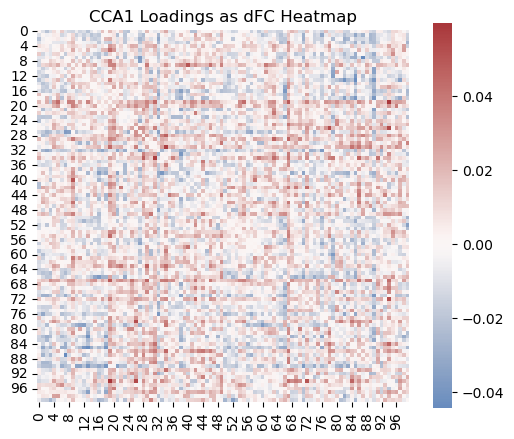

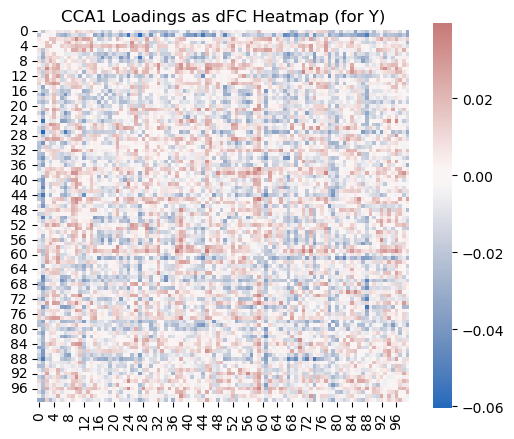

In [38]:
loading_heatmap(X_rest_sampled, technique=CCA, Y=X_task_sampled, which_component=1)

In [8]:
# Mimicing cPCA approach 1: foreground = whole time series; background = resting
# points from the same time series (X_rest is a subset of X).
# Should be clearer task vs rest cluster separation than real approach 1 where the
# background is an entirely different resting state time series.

cpca = CPCA()
cpca.fit_transform(X, X_rest, gui=True, active_labels=y)	# labels only for colouring
# Note: cPCA does the background subtraction on the covariance matricies
# so feature level, meaning this is just reducing the original data variance to
# emphasize variance in task-only directions, but the projected resting time points
# are not at the origin in cPCA space (not sample level cancellation).

The GUI may be slow to respond with large numbers of data points. Consider using a subset of the original data.


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='\\(\\log_{10}{\\alpha} \\)'…

EV by 1st Component: 0.46076323239399414
EV by 2nd Component: 0.025088089301805932


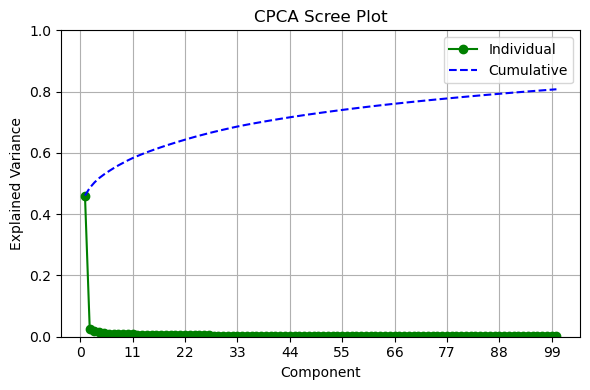

In [67]:
# Set a suitable alpha according to the biplots with varying alphas first
# Note: for cPCA, the contrastive sample covariance matrix is not necessarily
# positive semi-definite anymore, so some components eigenvalues = "variances" are negative
scree_plot(X=X, Y=X_rest, technique=CPCA, n_components=100, alpha=0.2)

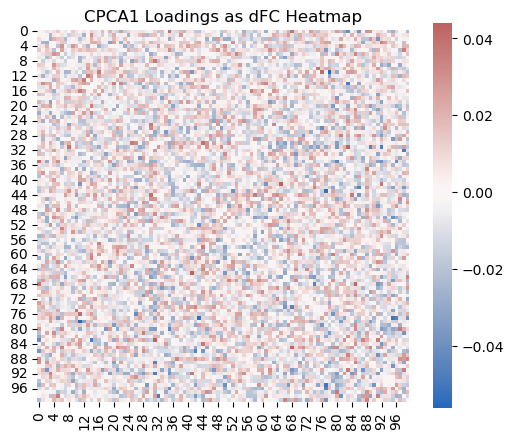

In [46]:
loading_heatmap(X=X, Y=X_rest, technique=CPCA, which_component=1, alpha=0.2)

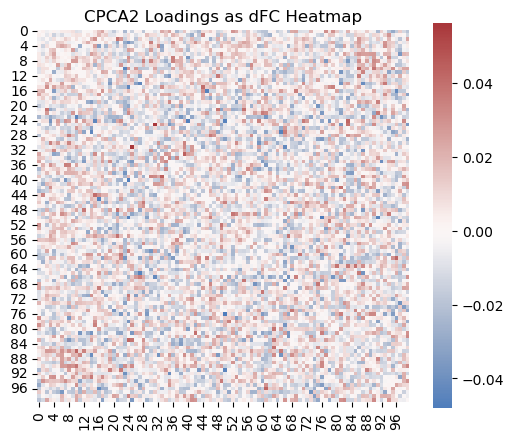

In [47]:
loading_heatmap(X=X, Y=X_rest, technique=CPCA, which_component=2, alpha=0.2)

In [10]:
# cPCA approach 2: purely task = foreground; rest = background
# No labels since all the time points shown are of task-active state.
cpca = CPCA()
cpca.fit_transform(X_task, X_rest, gui=True)

The GUI may be slow to respond with large numbers of data points. Consider using a subset of the original data.


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='\\(\\log_{10}{\\alpha} \\)'…

EV by 1st Component: 0.04931035073866575
EV by 2nd Component: 0.04782961519150847


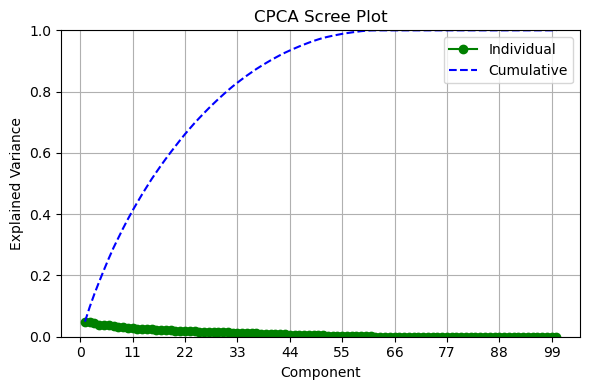

In [65]:
scree_plot(X=X_task, Y=X_rest, technique=CPCA, n_components=100, alpha=12)
# from trial and error: alpha = 0.8 got around 33% of contrastive variance explained by cPC1

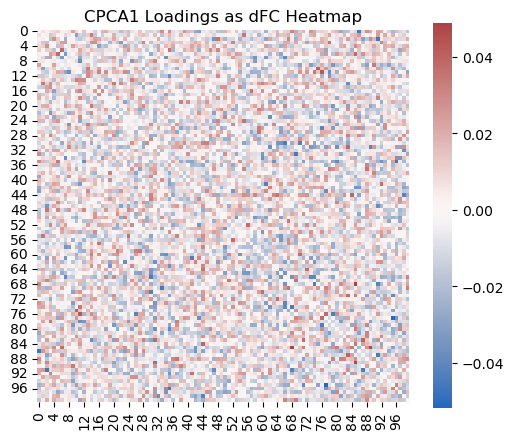

In [49]:
loading_heatmap(X=X_task, Y=X_rest, technique=CPCA, which_component=1, alpha=0.8)

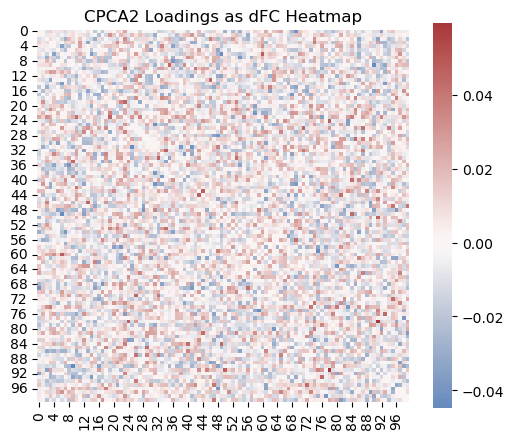

In [50]:
loading_heatmap(X=X_task, Y=X_rest, technique=CPCA, which_component=2, alpha=0.8)

/Users/kinichen/miniconda3/envs/neuro_jb_lab_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


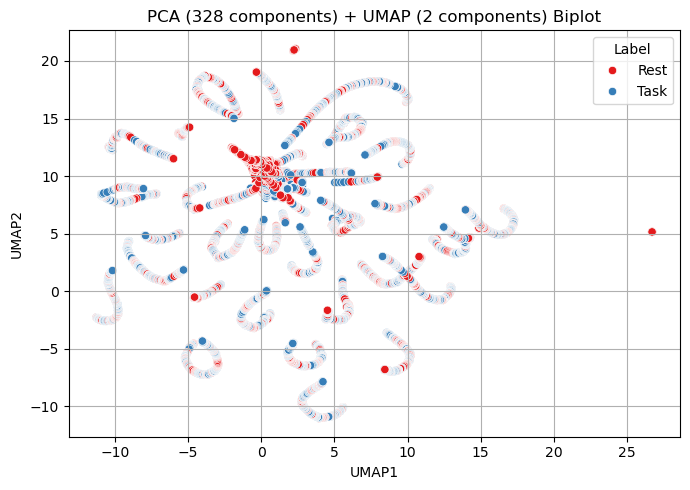

In [4]:
# Try PCA + UMAP for nonlinear patterns (if task vs rest can have any cluster separability)

# First, use PCA to reduce dimensions
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=328)	# need 328 components to explain 90% of variance in this dataset
X_pca = pca.fit_transform(X_scaled)

# Apply UMAP
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, 
					random_state=25)
X_umap = reducer.fit_transform(X_pca)

# Plot
df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df["Label"] = ["Rest" if label == 0 else "Task" for label in y]

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Label", palette="Set1")
plt.title(f"PCA ({pca.n_components_} components) + UMAP (2 components) Biplot")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True)
plt.tight_layout()
plt.show()

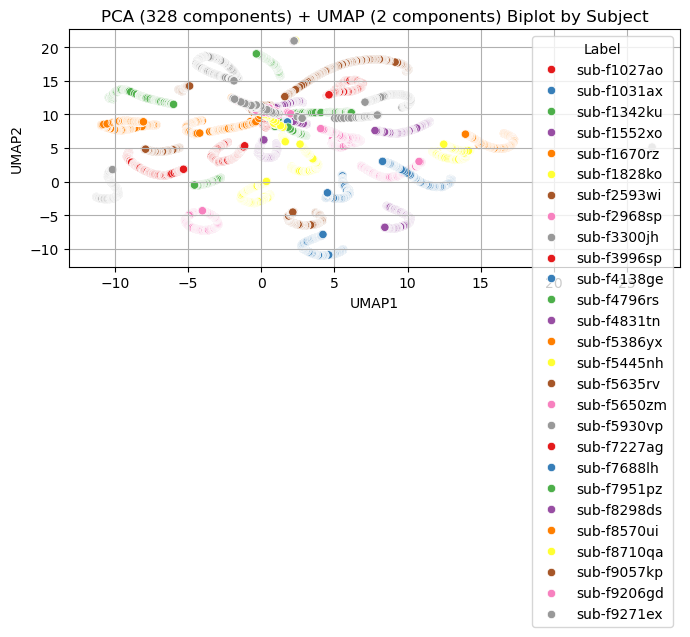

In [5]:
# Colour UMAP points by subject to understand "string" trajectories
# Plot
df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df["Label"] = subj_label

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Label", palette="Set1")
plt.title(f"PCA ({pca.n_components_} components) + UMAP (2 components) Biplot by Subject")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/kinichen/miniconda3/envs/neuro_jb_lab_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


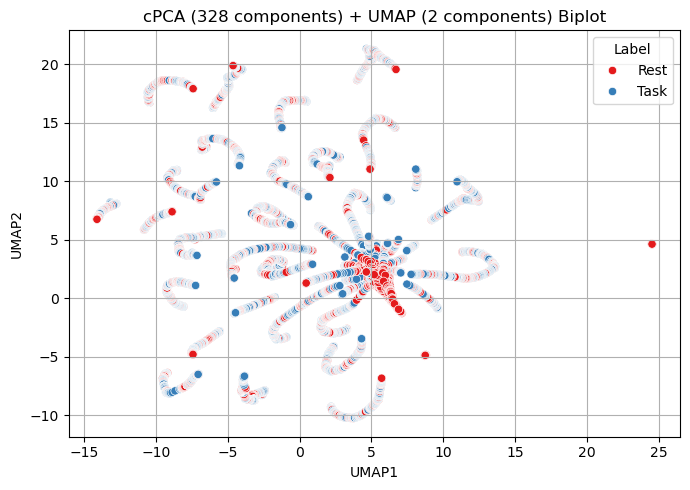

In [9]:
# Try cPCA + UMAP

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(X_rest)

model = CPCA(n_components=328)	# variance explained varies per alpha
X_cpca = model.fit_transform(X_scaled, Y_scaled, alpha_selection='manual', alpha_value=0.8)

# Apply UMAP
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, 
					random_state=25)
X_umap = reducer.fit_transform(X_cpca)

# Plot
df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df["Label"] = ["Rest" if label == 0 else "Task" for label in y]

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Label", palette="Set1")
plt.title("cPCA (328 components) + UMAP (2 components) Biplot")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True)
plt.tight_layout()
plt.show()


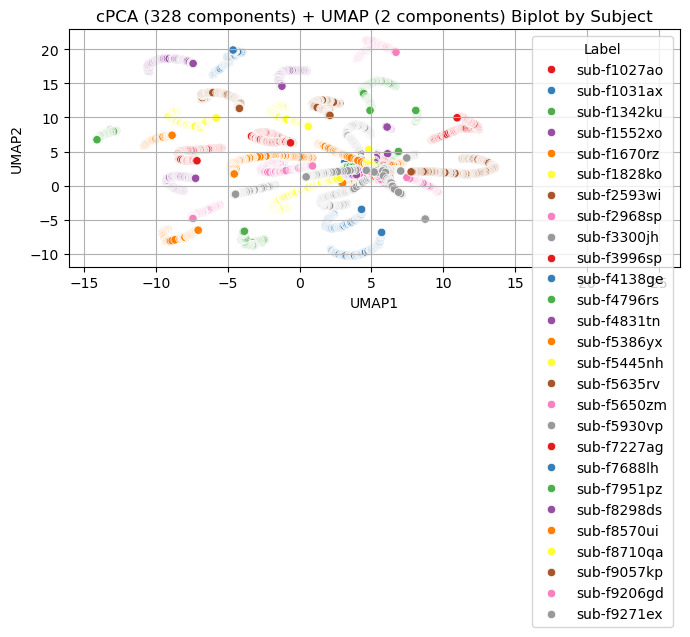

In [11]:
# Colour UMAP points by subject
df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df["Label"] = subj_label

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="Label", palette="Set1")
plt.title("cPCA (328 components) + UMAP (2 components) Biplot by Subject")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.grid(True)
plt.tight_layout()
plt.show()

/Users/kinichen/miniconda3/envs/neuro_jb_lab_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


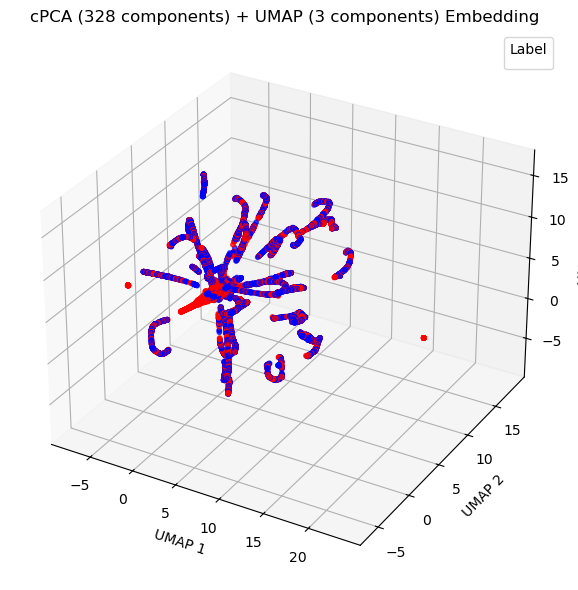

In [87]:
# Run UMAP in 3D
reducer_3D = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=3, random_state=25)
X_umap_3D = reducer_3D.fit_transform(X_cpca)

# Create DataFrame
df = pd.DataFrame(X_umap_3D, columns=["UMAP1", "UMAP2", "UMAP3"])
df["Label"] = ["Rest" if label == 0 else "Task" for label in y]

# Color map
label_to_color = {"Rest": "red", "Task": "blue"}
colors = df["Label"].map(label_to_color)

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

ax.plot(df["UMAP1"], df["UMAP2"], df["UMAP3"],
		   c=colors, s=10, alpha=0.7)

ax.set_title("cPCA (328 components) + UMAP (3 components) Embedding")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")

ax.legend(title="Label")
plt.tight_layout()
plt.show()


In [37]:
# Tensor decomposition

def build_subject_tensors(X, subject_ids):  # keys are the subject IDs
	subject_tensor_dict = defaultdict(list)
	for i, subj in enumerate(subject_ids):
		mat = vec_to_symmetric_matrix(X[i], ROI) # pass each row of concatenated matrix in
		subject_tensor_dict[subj].append(mat)
	for subj in subject_tensor_dict:
		subject_tensor_dict[subj] = np.stack(subject_tensor_dict[subj], axis=0)  
		# shape: (T_i, ROI, ROI) prism tensor for each subject ID
	return subject_tensor_dict

In [42]:
def extract_time_factors_cp(subject_tensor_dict, subject_ids, task_labels, cp_rank=2):
	"""Extract time factors from subject tensors using CP decomposition and
	associate them with task labels. Concatenated across subjects.

	Returns:
		X_final: Concatenated time factors for all subjects, shape (time_total, cp_rank)
		y_final: Corresponding concatenated task labels for all time points, shape (time_total,)
	"""
	X_features = []
	Y_labels = []

	for subj, tensor in subject_tensor_dict.items():    # tensor shape: (T_i, ROI, ROI)
		T = tensor.shape[0] # number of timepoints for this subject
		if min(T, ROI) < cp_rank:
			continue  # skip if not enough timepoints or regions

		try:    # for CP, same rank for all three dimensions
			weights, factors = parafac(tensor, rank=cp_rank, n_iter_max=100, init='svd')
			time_factors = factors[0]  # shape: (T_i, cp_rank)
		except Exception as e:
			print(f"Skipping subject {subj} due to CPD failure: {e}")
			continue

		# Get corresponding task labels for each subject
		mask_idx = [i for i, s in enumerate(subject_ids) if s == subj]
		assert len(mask_idx) == T

		X_features.append(time_factors)
		Y_labels.append(task_labels[mask_idx])

	X_final = np.vstack(X_features)
	y_final = np.hstack(Y_labels)
	return X_final, y_final

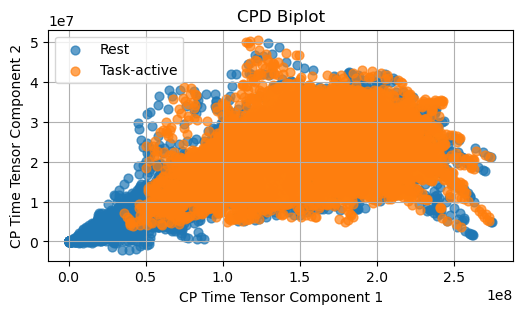

In [40]:
biplot(X, labels=y, technique="CPD")

In [43]:
def train_cp_classifier(X_cp, y_cp):
    X_scaled = StandardScaler().fit_transform(X_cp)
    clf = SVC(kernel='rbf', C=1.0, gamma='scale')
    scores = cross_val_score(clf, X_scaled, y_cp, cv=5, scoring='balanced_accuracy')
    print(f"Mean balanced test SVM accuracy: {scores.mean():.3f} ± {scores.std():.3f}")


def cp_task_prediction_pipeline(X, subject_ids, task_labels, cp_rank=2):
    print("Building subject tensors...")
    subject_tensor_dict = build_subject_tensors(X, subject_ids)

    print(f"Extracting CP time factor features (rank={cp_rank})...")
    X_cp, y_cp = extract_time_factors_cp(subject_tensor_dict, subject_ids, task_labels, cp_rank)

    print(f"Total samples: {X_cp.shape[0]}")
    print("Training classifier...")
    train_cp_classifier(X_cp, y_cp)

In [44]:
cp_task_prediction_pipeline(X, subject_ids=subj_label, task_labels=y, cp_rank=2)

Building subject tensors...
Extracting CP time factor features (rank=2)...
Total samples: 14680
Training classifier...
Mean balanced test SVM accuracy: 0.594 ± 0.012


In [45]:
# max rank 100 because 100 ROIs
cp_task_prediction_pipeline(X, subject_ids=subj_label, task_labels=y, cp_rank=100)

Building subject tensors...
Extracting CP time factor features (rank=100)...
Total samples: 14680
Training classifier...
Mean balanced test SVM accuracy: 0.586 ± 0.010
